In [ ]:
! pip install gender_guesser chardet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.3/379.3 kB 6.9 MB/s eta 0:00:00


In [ ]:
import chardet

def detect_encoding(file_path):
    with open(file_path, "rb") as f:
        result = chardet.detect(f.read(100000))  # check first 100KB
        return result["encoding"]


In [ ]:
import requests
import time
import csv
import pandas as pd
import gender_guesser.detector as gender
from collections import defaultdict

# Load list of key women from CSV
file_path = "/content/CPSC 572 Project Raw Dataset(Sheet1).csv"
encoding = detect_encoding(file_path)
key_women_df = pd.read_csv(file_path, encoding=encoding)

key_women = key_women_df['Name'].dropna().astype(str).str.strip().tolist()
key_women_lc = set(name.lower() for name in key_women)

# Gender detector
gender_detector = gender.Detector(case_sensitive=False)
def detect_gender(name, known_female=False):
    if known_female:
        return "Female"
    first = name.split()[0]
    g = gender_detector.get_gender(first)
    if g in ['female', 'mostly_female']:
        return "Female"
    elif g in ['male', 'mostly_male']:
        return "Male"
    else:
        return "Unknown"

# OpenAlex helper functions
def search_openalex_author(name):
    url = f"https://api.openalex.org/authors?filter=display_name.search:{name}"
    r = requests.get(url)
    if r.status_code != 200:
        print(f"Error searching for {name}")
        return None
    results = r.json().get("results", [])
    if not results:
        print(f"No results for {name}")
        return None
    return results[0].get("id")

def fetch_author_works(author_id):
    works = []
    page = 1
    cursor = "*"
    while True:
        url = f"https://api.openalex.org/works?filter=authorships.author.id:{author_id}&per_page=200&cursor={cursor}"
        print(f"   → Fetching page {page} (cursor={cursor})")
        r = requests.get(url)
        if r.status_code != 200:
            print(f"Failed to fetch works for {author_id}")
            break

        data = r.json()
        results = data.get("results", [])
        works.extend(results)

        cursor = data.get("meta", {}).get("next_cursor")
        if not cursor:
            break

        time.sleep(1)
        page += 1
    return works

# Process works to extract supervision edges
def extract_supervision_from_work(work):
    work_id = work.get("id")
    title = work.get("title", "")
    authorships = work.get("authorships", [])
    n = len(authorships)

    if n < 2:
        return []

    first = authorships[0]['author']['display_name'].strip()
    last = authorships[-1]['author']['display_name'].strip()
    all_authors = [a['author']['display_name'].strip() for a in authorships]

    first_lc = first.lower()
    last_lc = last.lower()

    # Only process if first or last is in key women
    if first_lc not in key_women_lc and last_lc not in key_women_lc:
        return []

    # Define supervision relationship
    supervisor = last
    supervisee = first
    supervisor_lc = last_lc
    supervisee_lc = first_lc

    supervisor_gender = "Female" if supervisor_lc in key_women_lc else detect_gender(supervisor)
    supervisee_gender = "Female" if supervisee_lc in key_women_lc else detect_gender(supervisee)

    return [{
        "work_id": work_id,
        "title": title,
        "supervisor": supervisor,
        "supervisee": supervisee,
        "supervisor_gender": supervisor_gender,
        "supervisee_gender": supervisee_gender,
        "coauthors": "; ".join(all_authors)
    }]

# Main logic
all_edges = []
seen_pairs = set()

for name in key_women:
    print(f"\n🔍 Searching for {name}")
    author_id = search_openalex_author(name)
    if not author_id:
        continue

    print(f"📚 Fetching works for {name} ({author_id})")
    works = fetch_author_works(author_id)
    print(f"✅ Retrieved {len(works)} works")

    for work in works:
        edges = extract_supervision_from_work(work)
        for edge in edges:
            key = (edge["work_id"], edge["supervisor"], edge["supervisee"])
            if key not in seen_pairs:
                all_edges.append(edge)
                seen_pairs.add(key)

# Write output to CSV
output_file = "supervision_from_openalex.csv"
with open(output_file, 'w', newline='', encoding='utf-8-sig') as f:
    writer = csv.writer(f)
    writer.writerow([
        "Work ID", "Title", "Supervisor", "Supervisee",
        "Supervisor Gender", "Supervisee Gender", "Coauthors", "Weight"
    ])
    for edge in all_edges:
        writer.writerow([
            edge["work_id"],
            edge["title"],
            edge["supervisor"],
            edge["supervisee"],
            edge["supervisor_gender"],
            edge["supervisee_gender"],
            edge["coauthors"],
            1
        ])

print(f"\n✅ Supervision data saved to: {output_file}")


Streaming output truncated to the last 5000 lines.

🔍 Searching for Mona Singh
📚 Fetching works for Mona Singh (https://openalex.org/A5085615320)
   → Fetching page 1 (cursor=*)
   → Fetching page 2 (cursor=Ils1NC4wLCAwLCAnaHR0cHM6Ly9vcGVuYWxleC5vcmcvVzIyMTkyMTU2MDYnXSI=)
   → Fetching page 3 (cursor=Ils1My4wLCAwLCAnaHR0cHM6Ly9vcGVuYWxleC5vcmcvVzIwMzYzMjEwMDInXSI=)
✅ Retrieved 201 works

🔍 Searching for Carla Gomes
📚 Fetching works for Carla Gomes (https://openalex.org/A5069030030)
   → Fetching page 1 (cursor=*)
   → Fetching page 2 (cursor=Ils3OS4wLCA2LCAnaHR0cHM6Ly9vcGVuYWxleC5vcmcvVzE0NjU3MDgzOSddIg==)
   → Fetching page 3 (cursor=Ils1NS4wLCAwLCAnaHR0cHM6Ly9vcGVuYWxleC5vcmcvVzI0MDM0ODU5OCddIg==)
✅ Retrieved 350 works

🔍 Searching for Abigail Sellen
📚 Fetching works for Abigail Sellen (https://openalex.org/A5054544784)
   → Fetching page 1 (cursor=*)
   → Fetching page 2 (cursor=Ils3Ny4wLCAyLCAnaHR0cHM6Ly9vcGVuYWxleC5vcmcvVzI0OTczNDkzMDAnXSI=)
   → Fetching page 3 (cursor=Ils1My4wLC

<ipython-input-5-6bbeff7f8fd1>:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=q1_counts.index, y=q1_counts.values, ax=axes[0, 0], palette="pastel")
<ipython-input-5-6bbeff7f8fd1>:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=q2_counts.index, y=q2_counts.values, ax=axes[0, 1], palette="muted")


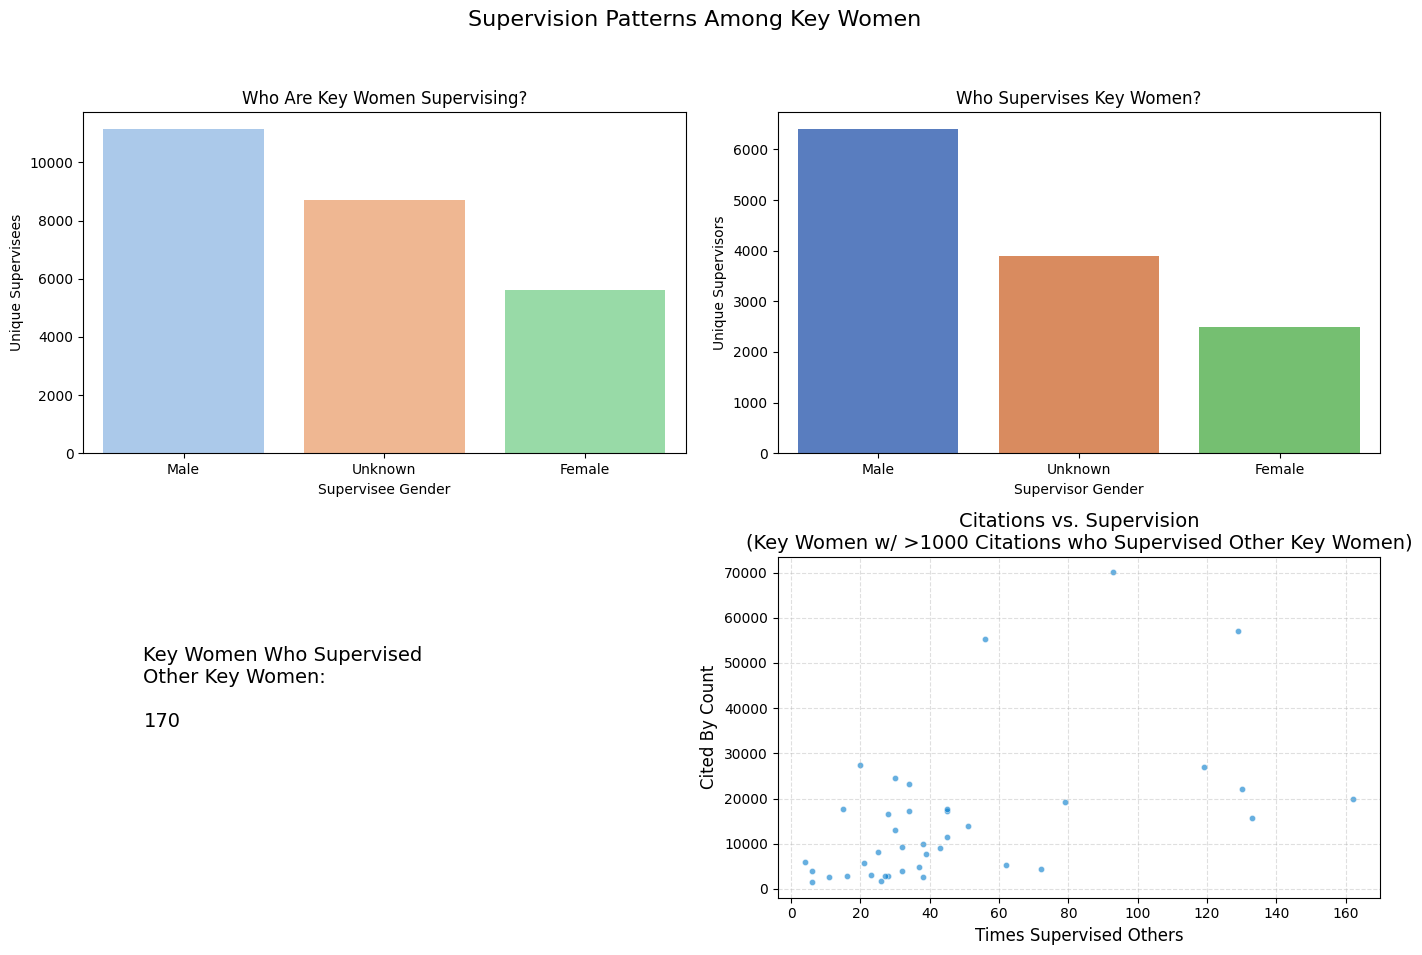

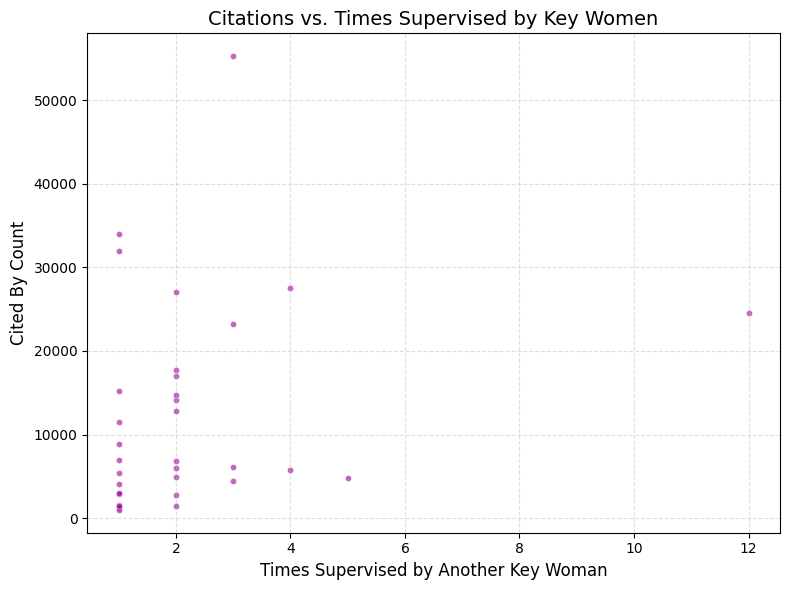

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import chardet

# Detect encoding for key women CSV
def detect_encoding(file_path):
    with open(file_path, "rb") as f:
        result = chardet.detect(f.read(100000))
        return result["encoding"]

# Load key women list
key_women_path = "CPSC 572 Project Raw Dataset(Sheet1).csv"
encoding = detect_encoding(key_women_path)
key_women_df = pd.read_csv(key_women_path, encoding=encoding)
key_women = key_women_df['Name'].dropna().astype(str).str.strip().tolist()
key_women_lc = set(name.lower() for name in key_women)

# Load data
supervision_df = pd.read_csv("supervision_from_openalex.csv", encoding="utf-8-sig")
nodes_df = pd.read_csv("nodes_undirected.csv", encoding="utf-8-sig")

# Clean column names and string values
supervision_df.columns = supervision_df.columns.str.strip()
nodes_df.columns = nodes_df.columns.str.strip()

for col in ["Supervisor", "Supervisee", "Display Name"]:
    if col in supervision_df.columns:
        supervision_df[col] = supervision_df[col].astype(str).str.strip()
    if col in nodes_df.columns:
        nodes_df[col] = nodes_df[col].astype(str).str.strip()

# Lowercase for internal matching
supervision_df["Supervisor_lc"] = supervision_df["Supervisor"].str.lower()
supervision_df["Supervisee_lc"] = supervision_df["Supervisee"].str.lower()

# Drop duplicate supervision records (same supervisor, supervisee, work)
supervision_df = supervision_df.drop_duplicates(subset=["Supervisor", "Supervisee", "Work ID"])

# === Q1: Do key women supervise more men or women? ===
q1_df = supervision_df[supervision_df["Supervisor_lc"].isin(key_women_lc)]
q1_counts = q1_df.drop_duplicates(subset=["Supervisor", "Supervisee"])["Supervisee Gender"].value_counts()

# === Q2: Are key women supervised more by men or women? ===
q2_df = supervision_df[supervision_df["Supervisee_lc"].isin(key_women_lc)]
q2_counts = q2_df.drop_duplicates(subset=["Supervisor", "Supervisee"])["Supervisor Gender"].value_counts()

# === Q3: How many key women supervised other key women ===
q3_filtered_df = supervision_df[
    supervision_df["Supervisor_lc"].isin(key_women_lc) &
    supervision_df["Supervisee_lc"].isin(key_women_lc)
]
q3_supervisor_set = q3_filtered_df["Supervisor"].dropna().unique()
q3_count = len(q3_supervisor_set)

# === Q4: Only include key women who supervised other key women AND have >1000 citations ===
supervised_kw = supervision_df[
    supervision_df["Supervisor_lc"].isin(key_women_lc) &
    supervision_df["Supervisee_lc"].isin(key_women_lc)
]["Supervisor"].unique()

supervised_others = q1_df.drop_duplicates(subset=["Supervisor", "Supervisee"])["Supervisor"].value_counts().reset_index()
supervised_others.columns = ["Display Name", "Supervision Count"]

was_supervised = q2_df.drop_duplicates(subset=["Supervisor", "Supervisee"])["Supervisee"].value_counts().reset_index()
was_supervised.columns = ["Display Name", "Supervised Count"]

citation_df = nodes_df[["Display Name", "Cited By Count"]].copy()

merged_stats = pd.merge(supervised_others, was_supervised, on="Display Name", how="outer").fillna(0)
merged_stats = pd.merge(merged_stats, citation_df, on="Display Name", how="left").fillna(0)

merged_stats = merged_stats[
    merged_stats["Display Name"].isin(supervised_kw) &
    (merged_stats["Cited By Count"] > 1000)
]

# === Q5: Citations vs being supervised by key women ===
q5_df = supervision_df[
    supervision_df["Supervisor_lc"].isin(key_women_lc) &
    supervision_df["Supervisee_lc"].isin(key_women_lc)
].drop_duplicates(subset=["Supervisor", "Supervisee", "Work ID"])

supervised_by_kw_counts = q5_df["Supervisee"].value_counts().reset_index()
supervised_by_kw_counts.columns = ["Display Name", "Supervised By KW Count"]

supervised_vs_citations = pd.merge(
    supervised_by_kw_counts,
    citation_df,
    on="Display Name",
    how="left"
).dropna()

# Plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Supervision Patterns Among Key Women", fontsize=16)

sns.barplot(x=q1_counts.index, y=q1_counts.values, ax=axes[0, 0], palette="pastel")
axes[0, 0].set_title("Who Are Key Women Supervising?")
axes[0, 0].set_ylabel("Unique Supervisees")
axes[0, 0].set_xlabel("Supervisee Gender")

sns.barplot(x=q2_counts.index, y=q2_counts.values, ax=axes[0, 1], palette="muted")
axes[0, 1].set_title("Who Supervises Key Women?")
axes[0, 1].set_ylabel("Unique Supervisors")
axes[0, 1].set_xlabel("Supervisor Gender")

axes[1, 0].text(
    0.1, 0.5,
    f"Key Women Who Supervised\nOther Key Women:\n\n{q3_count}",
    fontsize=14
)
axes[1, 0].axis("off")

sns.scatterplot(
    data=merged_stats,
    x="Supervision Count",
    y="Cited By Count",
    s=20,
    alpha=0.6,
    edgecolor="w",
    linewidth=0.5,
    color="#007acc",
    ax=axes[1, 1]
)
axes[1, 1].set_title("Citations vs. Supervision\n(Key Women w/ >1000 Citations who Supervised Other Key Women)", fontsize=14)
axes[1, 1].set_xlabel("Times Supervised Others", fontsize=12)
axes[1, 1].set_ylabel("Cited By Count", fontsize=12)
axes[1, 1].grid(True, linestyle='--', alpha=0.4)


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=supervised_vs_citations,
    x="Supervised By KW Count",
    y="Cited By Count",
    s=20,
    alpha=0.6,
    edgecolor="w",
    linewidth=0.5,
    color="#990099"
)
plt.title("Citations vs. Times Supervised by Key Women", fontsize=14)
plt.xlabel("Times Supervised by Another Key Woman", fontsize=12)
plt.ylabel("Cited By Count", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


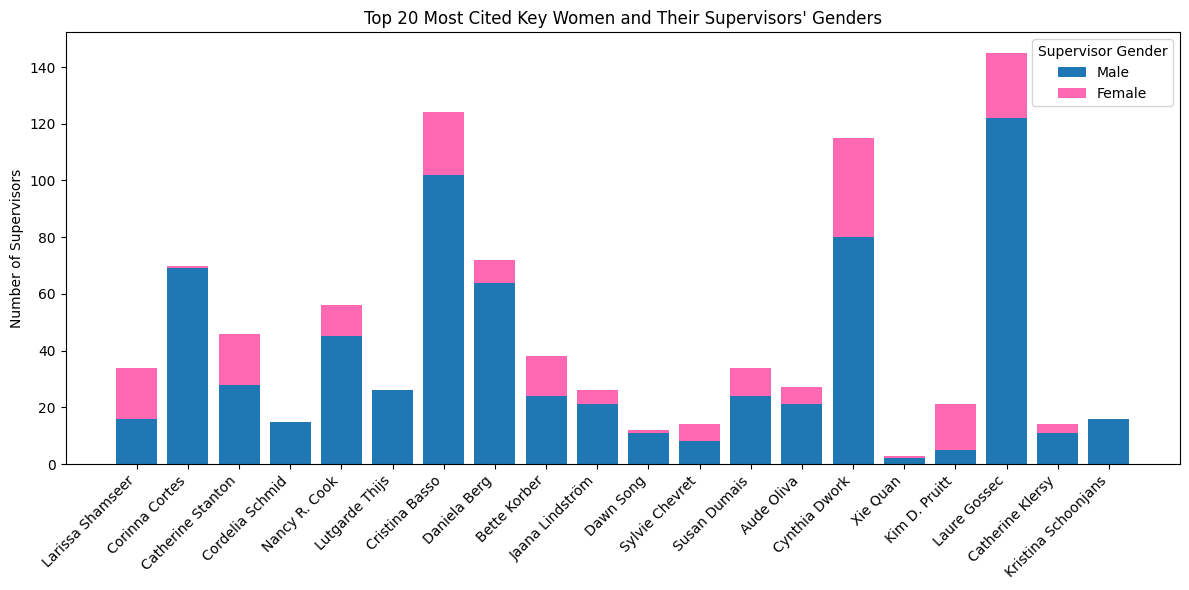

In [ ]:
# === Q6: Top 10 most cited key women & supervisor gender breakdown ===
key_women_nodes = nodes_df[nodes_df["Display Name"].str.lower().isin(key_women_lc)].copy()
key_women_nodes = key_women_nodes.sort_values(by="Cited By Count", ascending=False).head(20)

supervised_keywomen_df = supervision_df[
    supervision_df["Supervisee_lc"].isin(key_women_nodes["Display Name"].str.lower())
]

gender_count_list = []
for woman in key_women_nodes["Display Name"]:
    sup_data = supervised_keywomen_df[supervised_keywomen_df["Supervisee"].str.strip() == woman]
    male_count = (sup_data["Supervisor Gender"] == "Male").sum()
    female_count = (sup_data["Supervisor Gender"] == "Female").sum()
    gender_count_list.append({
        "Name": woman,
        "Male Supervisors": male_count,
        "Female Supervisors": female_count
    })

gender_df = pd.DataFrame(gender_count_list)

plt.figure(figsize=(12, 6))
bottoms = gender_df["Male Supervisors"]
p1 = plt.bar(gender_df["Name"], bottoms, label="Male", color="#1f77b4")
p2 = plt.bar(gender_df["Name"], gender_df["Female Supervisors"], bottom=bottoms, label="Female", color="#ff69b4")

plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Supervisors")
plt.title("Top 20 Most Cited Key Women and Their Supervisors' Genders")
plt.legend(title="Supervisor Gender")
plt.tight_layout()
plt.show()
